# Reinforcement Learning: Learning to Play Tic-Tac-Toe with Q-Learning

## Introduction 
 
The goal of reinforcement learning is to interact with the environment and use trial-and-error to learn the best action for each state. Prescribing an action for a state is called a policy. The optimal policy is the policy that maximizes the sum of
all future expected rewards. 

The optimal action in a state $s$ can be determined from the Q-values $Q(s, a)$ which is the expected utility of
choosing $a$ in $s$ and the following the current policy till a terminal state is reached. The optimal action is the 
action with the largest Q-value for the state. The policy implementing this idea is called a greedy policy. 

For small problems, the Q-value function can be expressed as a table. 
We implement here the table-based TD(0) algorithm as described in Chapter 6 of Sutton and Barto (2020). 

**Algorithm: Q-learning (off-policy TD control) for estimating $\pi^*$**

Parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$, a discount factor $\gamma$

Initialize $Q(s, a) = 0$, for all $s \in S^+, a \in A(s)$

Loop for each episode:
  * Initialize $s$
  * Loop for each step of episode:
    *  Choose $a$ for $s$ (the state in the current step) using a policy derived from $Q$ (e.g., $\epsilon$-greedy)
    *  Take action $a$, observe the reward $r$ and the next state $s'$
    *  $Q(s, a) \leftarrow Q(s, a) + \alpha [r +  \gamma \max_a' Q(s', a') - Q(s, a)]$
    *  $s \leftarrow s'$
  * until $s$ is terminal
 
The idea of this iterative algorithm is to make in every step $Q(s, a)$ a little more similar to 
the immediate reward plus the expected utility of the best action in the next state expressed as $r + Q(s', a')$. The algorithm is called temporal differencing since it used the 
difference between Q-values at state $s$ and the next (i.e., later) state $s'$. This difference is also
called the TD-error.

Different to the description in Sutton and Batro (2020), we will implement the algorithm as an agent function that can interact with an environment. An example is shown in AIMA Figure 22.8.

Also, there is no immediate reward in games like tic-tac-toe. A reward is only available when the game ends. This makes the problem actually harder.

## Q-Table Size

First, we need to establish that the Q-table will fit in memory. The table implements the function $Q: S \times A \rightarrow \mathbb{R}$ so it has number of states times number of actions entries.

We can estimate this in the following way:

In [29]:
import math

print("level\tboards\tactions\tQ table entries")
sum = 0

for i in range(0,9):
    boards = math.comb(9, i) * math.comb(i, math.floor(i/2))
    actions = 9 - i
    print(i, "\t", 
          boards, "\t",
          actions, "\t",
          boards * actions)
    sum += boards * actions

sum

level	boards	actions	Q table entries
0 	 1 	 9 	 9
1 	 9 	 8 	 72
2 	 72 	 7 	 504
3 	 252 	 6 	 1512
4 	 756 	 5 	 3780
5 	 1260 	 4 	 5040
6 	 1680 	 3 	 5040
7 	 1260 	 2 	 2520
8 	 630 	 1 	 630


19107

This game has no cycles so all of the boards are unique.
However, the number is an upper bound since some boards are not reachable since the game is over once one player wins. Given this analysis, the Q-table should easily fit in memory and
learning all these values should not take too much time.

## Finding a Policy using Q-Learning

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py).

In [30]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

Define the immediate reward for a board and a player. Remember, the reward is only defined in this game for the terminal state and `utility()` return `None` otherwise.

In [31]:
def reward (board, player):
    """Return the reward for the board position."""
    
    u = utility(board, player)
    if u == None:
        return 0
    
    return u

We need argmax with randomly breaking ties.

In [32]:
import numpy as np

def argmax_rand(b):
    return np.random.choice(np.flatnonzero(b == np.max(b)))

In [33]:
class QAgent:
    def __init__(self, epsilon = 0.1, alpha = 0.1, gamma = 0.9, player = 'x'):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player
        self.reset()
        
    def reset(self):
        self.Q = dict() # Q-table, empty means all entries are initially 0
        self.s = None
        self.a = None
        if DEBUG:
                print("Resetting QAgent")

    def play(self, s, r, player):
        global DEBUG
        
        if player != self.player:
            print("Error: I was not trained to play as", player)
            return None

        # Update Q-table with final reward, no more actions possible
        if (r != None):
            # we directly set the Q-value with to the final reward
            self.Q[(tuple(self.s), self.a)] = r
            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "with reward", r)

            self.s = None
            self.a = None
            return None

        
        # Update Q-table while game is not over
        
        # We use in the update a zero immediate reward 
        r = 0
        s_prime = s

        if self.s is not None and self.a is not None:
            max_Q_sp_a = np.max([self.Q.get((tuple(s_prime), x), 0) for x in actions(s_prime)])
            Q_sa = self.Q.get((tuple(self.s), self.a), 0)
            self.Q[(tuple(self.s), self.a)] = Q_sa + self.alpha * (r + self.gamma * max_Q_sp_a - Q_sa)

            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "to", self.Q[(tuple(self.s), self.a)])


        # Determine new action using epsilon-greedy strategy
        if np.random.uniform() < self.epsilon:
            # random action
            a = np.random.choice(actions(s))
            if DEBUG:
                print("Chosen random action:", a)
        else:
            # greedy action (best action given current Q-values)
            a = actions(s)[argmax_rand([self.Q.get((tuple(s), x), 0) for x in actions(s)])]
            if DEBUG:
                print("Chosen greedy action:", a)

        # remember state and action
        self.s = s_prime
        self.a = a

        return a

## Experiments

### The Environment and a Random Baseline Player

The environment for RL is slightly different, since the agent gets in addition to the percepts 
also the immediate reward information `r`.

**Note:** In this game, there is no immediate reward till the game is done. 
We call the agent function when the game is done with the reward.

In [34]:
def switch_player(player, x, o):
    if player == 'x':
        return 'o', o
    else:
        return 'x', x

def play(x, o, N = 100):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'x': 0, 'o': 0, 'd': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 'x', x
        
        while True:
            a = fun(board, None, player)
            board = result(board, player, a)
            
            u = utility(board, player = 'x')   # reward; returns None if the game is not done.
            
            if u != None:
                if (u == 1):
                    results['x'] += 1
                elif (u == -1):
                    results['o'] += 1
                elif (u == 0):
                    results['d'] += 1       
                
                # show agents their final reward
                x(board, u, 'x')
                o(board, u * -1, 'o')
                break
            
            player, fun = switch_player(player, x, o)   
    
    return results

Implement a completely randomized player agent can be used as a weak baseline. Immediate reward is ignored.

In [35]:
def random_player(board, r, player = None):
    """Simple player that chooses a random empty square (equal probability of all permissible actions). 
    player is unused."""
    if (r != None):
        return None    
    
    return np.random.choice(actions(board))

## Q-Learning Agent vs. Random

The agent learns for every game that it plays. 
We start with the first 100 games to see how bad it initially is.
For the final 1000 games, we set $\epsilon = 0$ so the 
agent only makes greedy moves.

The hyperparameters $\epsilon$ and $\alpha$ could be tuned.


### Train a Q-learning agent for playing x

In [36]:
print("Q-Learning vs. Random:")

DEBUG = False

qplayer_x = QAgent(player = 'x', epsilon = 0.2, alpha = 0.2)
qplayer_x.reset()

print("Initially, the performance is not better than a random player!")
display(play(qplayer_x.play, random_player, N = 100))

print("Play to learn how to play against a random player.")
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))

print("Set epsilon to zero to make the agent greedy and play again:")
qplayer_x.epsilon = 0.0
display(play(qplayer_x.play, random_player, N = 1000))

print("Q-table size:", len(qplayer_x.Q))
qplayer_x.Q

Q-Learning vs. Random:
Initially, the performance is not better than a random player!


{'x': 65, 'o': 27, 'd': 8}

Play to learn how to play against a random player.


{'x': 739, 'o': 188, 'd': 73}

{'x': 824, 'o': 126, 'd': 50}

{'x': 852, 'o': 112, 'd': 36}

{'x': 850, 'o': 102, 'd': 48}

{'x': 882, 'o': 84, 'd': 34}

{'x': 852, 'o': 103, 'd': 45}

{'x': 873, 'o': 84, 'd': 43}

{'x': 882, 'o': 76, 'd': 42}

{'x': 887, 'o': 70, 'd': 43}

{'x': 890, 'o': 75, 'd': 35}

Set epsilon to zero to make the agent greedy and play again:


{'x': 988, 'o': 1, 'd': 11}

Q-table size: 3626


{((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 7): 0.32223810044708134,
 (('o', ' ', ' ', ' ', ' ', ' ', ' ', 'x', ' '), 1): 0.5730952224469547,
 (('o', 'x', ' ', ' ', ' ', ' ', ' ', 'x', 'o'), 6): -1,
 (('o', 'x', ' ', ' ', ' ', 'o', 'x', 'x', 'o'), 3): -1,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 1): 0.793139105722585,
 (('o', 'x', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 7): 0.5722788598403716,
 (('o', 'x', ' ', ' ', ' ', ' ', 'o', 'x', ' '), 4): 1,
 ((' ', ' ', 'o', ' ', ' ', ' ', ' ', 'x', ' '), 4): 0.47391565956449466,
 ((' ', ' ', 'o', ' ', 'x', ' ', 'o', 'x', ' '), 1): 1,
 ((' ', 'x', 'o', ' ', ' ', ' ', ' ', ' ', ' '), 5): 0.4055790717001649,
 ((' ', 'x', 'o', ' ', 'o', 'x', ' ', ' ', ' '), 8): 0.0,
 ((' ', 'x', 'o', ' ', 'o', 'x', ' ', 'o', 'x'), 3): 0.0,
 (('o', 'x', 'o', 'x', 'o', 'x', ' ', 'o', 'x'), 6): 0,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 3): 0.4971695786821592,
 (('o', ' ', ' ', 'x', ' ', ' ', ' ', ' ', ' '), 2): 0.0,
 (('o', ' ', 'x', 'x', ' ', ' ',

### Train a Q-learning agent for playing o.

In [37]:
print("Random vs. Q-Learning:")

DEBUG = False

qplayer_o = QAgent(player = 'o', epsilon = 0.2, alpha = 0.2)
qplayer_o.reset()

print("Initially, the performance is not better than a random player!")
display(play(random_player, qplayer_o.play, N = 1000))

print("Play to learn how to play against a random player.")
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))

print("Set epsilon to zero to make the agent greedy and play again:")
qplayer_o.epsilon = 0.0
display(play(random_player, qplayer_o.play, N = 1000))

print("Q-table size:", len(qplayer_o.Q))
qplayer_o.Q

Random vs. Q-Learning:
Initially, the performance is not better than a random player!


{'x': 544, 'o': 328, 'd': 128}

Play to learn how to play against a random player.


{'x': 388, 'o': 478, 'd': 134}

{'x': 322, 'o': 534, 'd': 144}

{'x': 254, 'o': 607, 'd': 139}

{'x': 219, 'o': 642, 'd': 139}

{'x': 232, 'o': 609, 'd': 159}

{'x': 187, 'o': 635, 'd': 178}

{'x': 187, 'o': 669, 'd': 144}

{'x': 201, 'o': 653, 'd': 146}

{'x': 184, 'o': 647, 'd': 169}

{'x': 187, 'o': 668, 'd': 145}

Set epsilon to zero to make the agent greedy and play again:


{'x': 59, 'o': 789, 'd': 152}

Q-table size: 5229


{(('x', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 4): 0.24101567804798488,
 (('x', ' ', 'x', ' ', 'o', ' ', ' ', ' ', ' '), 8): 0.0,
 (('x', ' ', 'x', ' ', 'o', 'x', ' ', ' ', 'o'), 3): -1,
 ((' ', ' ', ' ', ' ', ' ', 'x', ' ', ' ', ' '), 0): 0.2760605338668074,
 (('o', 'x', ' ', ' ', ' ', 'x', ' ', ' ', ' '), 3): 0.7664868694187231,
 (('o', 'x', ' ', 'o', ' ', 'x', ' ', 'x', ' '), 6): 1,
 ((' ', ' ', ' ', ' ', 'x', ' ', ' ', ' ', ' '), 7): 0.14939347140309706,
 ((' ', ' ', ' ', ' ', 'x', ' ', 'x', 'o', ' '), 3): -1,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', 'x', ' '), 2): 0.6722605875623263,
 ((' ', 'x', 'o', ' ', ' ', ' ', ' ', 'x', ' '), 3): -1,
 ((' ', 'x', 'o', 'o', ' ', 'x', ' ', 'x', ' '), 0): 0.0,
 (('o', 'x', 'o', 'o', ' ', 'x', 'x', 'x', ' '), 4): -1,
 ((' ', ' ', 'x', ' ', ' ', ' ', ' ', ' ', ' '), 0): 0.5210506688659867,
 (('o', ' ', 'x', ' ', ' ', ' ', ' ', 'x', ' '), 1): 0.032400000000000005,
 (('o', 'o', 'x', ' ', ' ', ' ', 'x', 'x', ' '), 8): 0.0,
 (('o', 'o', 'x', ' ', ' ',

### Q-Learning vs. Q-Learning
Let two Q-learning agents play each other. This is called self play. Note that both agents already have been trained against a random agent.

In [38]:
print("Q-Learning vs. Q-Learning:")

# turn on a little exploration
print("exploration with epsilon = 0.2:")
qplayer_x.epsilon = 0.2
qplayer_o.epsilon = 0.2

display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))

# reduce exploration. The agent will now play fewer random moves.
print("Result exploration to epsilon = 0.01:")
qplayer_x.epsilon = 0.01
qplayer_o.epsilon = 0.01

display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))

print("Result with no exploration (epsilon = 0):")
qplayer_x.epsilon = 0
qplayer_o.epsilon = 0
display(play(qplayer_x.play, qplayer_o.play, N = 1000))



Q-Learning vs. Q-Learning:
exploration with epsilon = 0.2:


{'x': 1721, 'o': 1138, 'd': 2141}

{'x': 1720, 'o': 1019, 'd': 2261}

{'x': 1679, 'o': 908, 'd': 2413}

{'x': 1626, 'o': 926, 'd': 2448}

{'x': 1664, 'o': 908, 'd': 2428}

Result exploration to epsilon = 0.01:


{'x': 180, 'o': 102, 'd': 4718}

{'x': 160, 'o': 85, 'd': 4755}

{'x': 123, 'o': 60, 'd': 4817}

{'x': 119, 'o': 55, 'd': 4826}

Result with no exploration (epsilon = 0):


{'x': 0, 'o': 0, 'd': 1000}

At the end, no agent should be able to win.

### Look at the Q-tables

In [39]:
print("Q-table size of x:", len(qplayer_x.Q))
print("Q-table size of o:", len(qplayer_o.Q))

Q-table size of x: 6055
Q-table size of o: 6420


Look at Q-table entries for a few boards. We show the action and the Q-value from the table. `nan` (i.e., not a number) means the action has not been tried and there is no Q-value in the table.

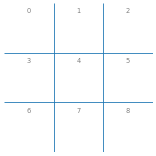

[[0, 0.0],
 [1, 0.0],
 [2, 0.0],
 [3, 0.0],
 [4, 0.0],
 [5, 0.0],
 [6, 0.0],
 [7, 0.0],
 [8, 0.0]]

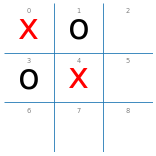

[[2, 0.0], [5, nan], [6, nan], [7, nan], [8, nan]]

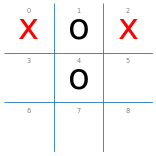

[[3, -1], [5, -1], [6, -1], [7, 0.0], [8, -1]]

In [40]:
Q = qplayer_x.Q

def find_q(s):
    return [[x, round(Q.get((tuple(s), x), np.nan),2)] for x in actions(s)]


board = empty_board()
show_board(board)
display(find_q(board))


board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
show_board(board)
display(find_q(board))


board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'
show_board(board)
display(find_q(board))